## a-AlphaBio homework problem
### Mark Thompson
### Started April 29, 2024 

#### scFv single-chain fragments of Pembrolizumab; which targets the programmed cell death protein 1 (PD-1) receptor of lymphocytes.

---------------
## TODO:
* <span style="color:red">Examine possible use of sequence_alpha?? (there is only 1 unique sequence here though).</span>

* <span style="color:red">Make sure Kd, Kd_lower_bound ,Kd_upper_bound properly ordered</span>
* <span style="color:red">Examine: q_value: The false discovery rate of the Kd measurement, relative to negative controls</span>


-----------
## Dataset 1 summary (from below analysis)
* 29199 unique aa sequences for scFv (split 90/10 train/val)
* all Kd values > 0 (no NANs)
* all sequences are same length: 246 residues


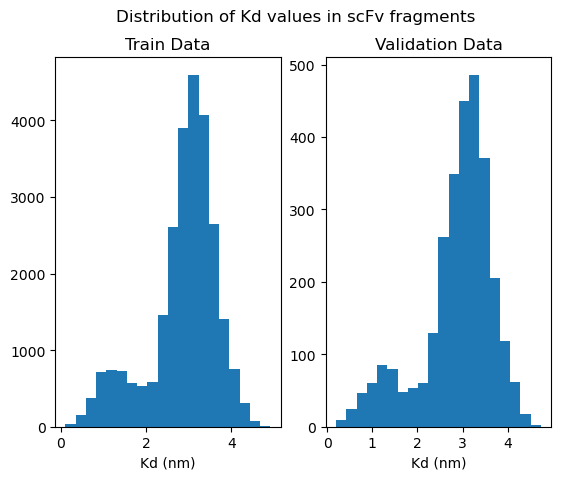

-----------

In [1]:
%load_ext autoreload

In [2]:
%autoreload
# import libraries
import numpy as np
import pickle as pk
import pandas as pd
import math
import os

----
### Data set analysis
* remove rows with NAN for Kd (note: NAN may indicate a non-binding or very very poor binding event. I could impute a very high value for Kd for these cases.  I will ignore them in this first pass)

* also check for any Kd values < 0 (there were some in the dataset from the Nature paper)
* identify duplicate sequences and accumulate Kd values for these.
* for duplicates, take the Kd value as the mean of the Kd values over the duplicate sequences.  Caveat: eyeball these first to ensure the Kd values are NOT widely spread in value.

In [18]:
data_file = './alphaseq_data_train.csv'
df = pd.read_csv(data_file)
rows1 = df.shape[0]
print('starting dataframe has', rows1, 'rows')
print(df.columns.tolist())

starting dataframe has 30049 rows
['description_a', 'sequence_a', 'description_alpha', 'sequence_alpha', 'Kd', 'Kd_lower_bound', 'Kd_upper_bound', 'q_value']


In [26]:
# Remove Kd nans
#
df = df.dropna(subset=['Kd'])
rows2 = df.shape[0]
print('after removing nans, dataframe has', rows2, 'rows; (there were', rows1-rows2, 'rows with Kd=nan)')

after removing nans, dataframe has 29358 rows; (there were 691 rows with Kd=nan)


In [51]:
# Remove Kd vals that are negative
#
num_negatives = (df[df['Kd'] > 0]).shape[0] - rows2
print('There are', num_negatives, 'Kd values < 0')

There are 0 Kd values < 0


In [36]:
# Identify duplicate sequences and process their multiple Kd values
#
seqs = {} # will contain a list for binding energies for each unique sequence
for index, row in df.iterrows():
    seq = row['sequence_a']
    affinity = row['Kd']
    if seq not in seqs:
        seqs[seq] = list()
        seqs[seq].append(affinity)
    else:
        seqs[seq].append(affinity)

print('Number of unique sequences:', len(seqs))
print('First few entries')
for i, (k, v) in enumerate(seqs.items()):
    assert len(v) > 0, 'empty set for sequence'
    print(i, ':', 'num values:', len(v), ', values:', v)
    if i > 2:
        break

Number of unique sequences: 29199
First few entries
0 : num values: 51 , values: [1.2419628532129607, 1.3793547618634392, 1.1528594007742932, 1.1234871650658107, 1.161712868152616, 1.2252489460847826, 1.14559440926973, 1.128879976800924, 1.7984106042189367, 1.230264572870599, 1.1621030996620227, 2.088821673811601, 1.3130583571705543, 1.2244431358569834, 1.07105556422146, 1.2743967956448543, 1.8403837615756624, 1.1809028058854487, 1.2259335606406836, 1.3874729233398604, 1.0762728869166516, 1.4316441320626296, 1.2952890150171044, 1.3216025753034089, 1.2125037883629624, 1.1203545820858132, 1.3599596604472983, 1.1974700981104824, 1.3800538510679736, 1.2916007065814554, 1.2630263933743286, 1.2375541773776035, 1.1098785336541042, 1.7517630817399734, 1.0187118584110166, 1.1040702794938184, 1.3817934595452217, 1.3580189710309725, 1.123542623094604, 1.0643779140832734, 1.61937429500583, 2.1767792021213417, 1.141271146637056, 1.8645551415983483, 1.3440541152050225, 1.296708623038473, 1.410295033

In [42]:
# Calc the mean Kd for all unique sequences:
# calc the mean of the binding affinities for each sequence
seqs_mean_Kd = {}
for k,v in seqs.items():
    seqs_mean_Kd[k] = np.mean(v)

# Is there a distribution of lengths for scFv ?
s = set([len(k) for k,v in seqs_mean_Kd.items()])
print('Total number of sequence lengths:', len(s), ', and it is', s, 'aa long')

Total number of sequence lengths: 1 , and it is {246} aa long


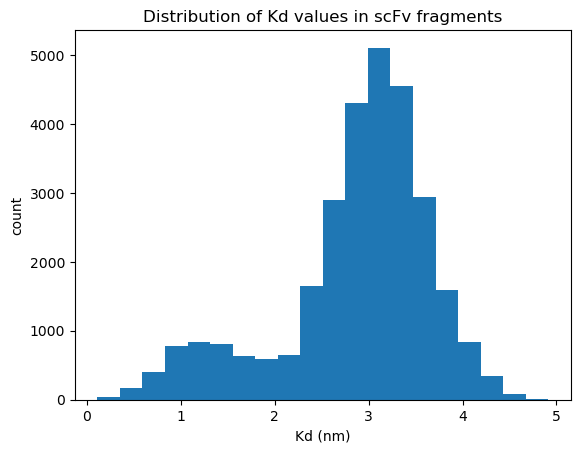

In [49]:
# Histogram of Kd values
#
kds = [v for k,v in seqs_mean_Kd.items()]
plt.hist(kds, bins=20)
plt.xlabel('Kd (nm)')
plt.ylabel('count')
plt.title('Distribution of Kd values in scFv fragments')
plt.show()

# Interesting that it appears somewhat bi-modal

### Create train/val split  (90/10)

In [54]:
# Create the train and test sets and save as csv files
seqs = [k for k,v in seqs_mean_Kd.items()]
kds  = [v for k,v in seqs_mean_Kd.items()]

df_out = pd.DataFrame({'sequence_a': seqs, 'Kd': kds})

# Train/val split 90/10
df_train = df_out.sample(frac=0.9, random_state=42)
df_val = df_out.drop(df_train.index)
print('train:', df_train.shape, ', val:', df_val.shape)

# save to csv
df_train.to_csv('./data/train_set.csv', index=False)
df_val.to_csv('./data/val_set.csv', index=False)


train: (26279, 2) , val: (2920, 2)


### Ensure that train and val sets show same qualitative bimodal shape like above

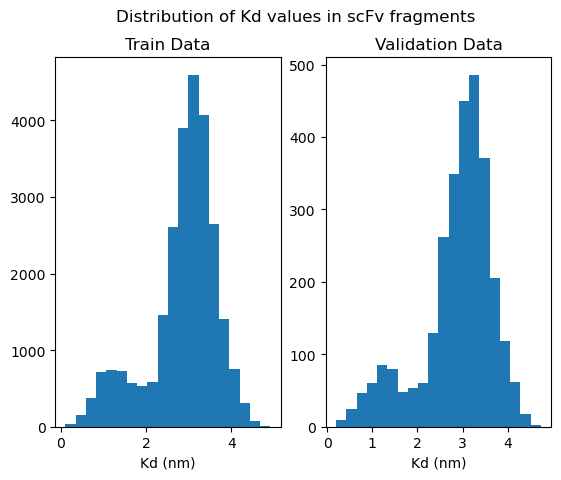

In [74]:
# Histogram of Kd values
#
kds_train = df_train['Kd'].to_list()
kds_val = df_val['Kd'].to_list()

fig, axs = plt.subplots(1, 2)
fig.suptitle('Distribution of Kd values in scFv fragments')
axs[0].hist(kds_train, bins=20)
axs[0].set_title('Train Data')

axs[1].hist(kds_val, bins=20)
axs[1].set_title('Validation Data')

for ax in axs.flat:
    ax.set(xlabel='Kd (nm)')


